#### Minimum Weight-Perfect Matching Weight Calibration Evaluation

In this notebook we evaluate the single qubit lifetime for different MWPM weights under depolarizing noise without measurement errors (as MWPM is used as referee decoder).

In [2]:
from deepq.Function_Library import *
from deepq.Environments import *

import numpy as np
import matplotlib.pyplot as plt

In [14]:
d = 7
error_model = "DP"
p_phys = 0.001
p_meas = p_phys
total_steps = 20_000
p_phys_list = [0.001, 0.003, 0.007, 0.009, 0.013]
mwpm_scale = {}

for scale in [0., .1, .3, .5]:
  mwpm_scale[scale] = {}
  for p_phys in p_phys_list:
    mwpm_scale[scale][p_phys] = {}
    p_meas = p_phys
    mwpm_weights = np.random.normal(loc=1, scale=scale, size=(d**2+1,))

    noise_model = NoiseFactory(error_model, d, p_phys).generate()
    env = Surface_Code_Environment_Multi_Decoding_Cycles(d=d,
                                                        p_meas=p_meas,
                                                        noise_model=noise_model,
                                                        use_Y=False,
                                                        volume_depth=d,
                                                        static_decoder=None,
                                                        mwpm_weights=mwpm_weights)

    env.reset()
    avg_qubit_lifetime_steps = []
    avg_env_steps = []
    steps = 0
    for _ in range(total_steps):
      # we do not correct any qubits and apply identity action
      _, _, done, _ = env.step(env.identity_index)
      if done:
        # print(f"Encountered Episode end, steps: {steps}, done: {done}, lifetime: {env.lifetime}")
        avg_qubit_lifetime_steps.append(env.lifetime)
        avg_env_steps.append(steps)
        env.reset()
        steps = 0

      steps += int(not done)

    avg_qubit_lifetime_steps.append(env.lifetime)
    avg_env_steps.append(steps)

    print(f"stddev: {scale}")
    print(f"Avg. Qubit lifetime: {np.mean(avg_qubit_lifetime_steps)}")
    print(f"Avg. Environment steps: {np.mean(avg_env_steps)}")
    mwpm_scale[scale][p_phys]['avg_qubit_lifetime'] = np.mean(avg_qubit_lifetime_steps)
    mwpm_scale[scale][p_phys]['avg_env_steps'] = np.mean(avg_env_steps)

Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.001
stddev: 0.0
Avg. Qubit lifetime: 252.91151919866445
Avg. Environment steps: 32.390651085141904
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.003
stddev: 0.0
Avg. Qubit lifetime: 94.02447980416157
Avg. Environment steps: 11.240514075887393
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.007
stddev: 0.0
Avg. Qubit lifetime: 47.490037539705455
Avg. Environment steps: 4.775628068149004
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.009
stddev: 0.0
Avg. Qubit lifetime: 40.02805280528053
Avg. Environment steps: 3.714992927864215
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.013
stddev: 0.0
Avg. Qubit lifetime: 31.315213615838832
Avg. Environment steps: 2.4736019451198334
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.001
stddev: 0.1
Avg. Qubit lifetime: 262.5486111111111
Avg. Environment steps

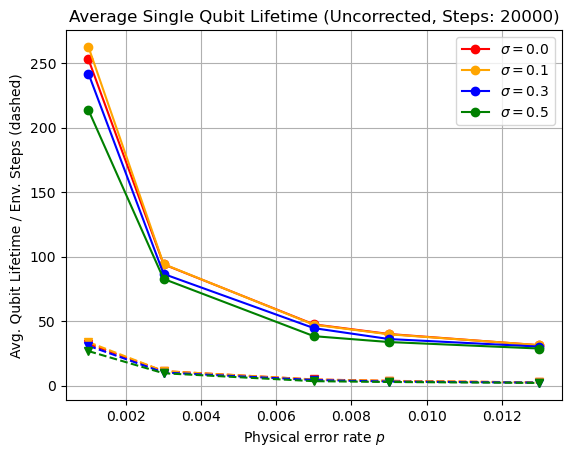

In [15]:
colors = ['red', 'orange', 'blue', 'green']

for index, scale in enumerate([0., .1, .3, .5]):
  avg_qubit = [mwpm_scale[scale][p]['avg_qubit_lifetime'] for p in p_phys_list]
  avg_env = [mwpm_scale[scale][p]['avg_env_steps'] for p in p_phys_list]
  plt.plot(p_phys_list, avg_qubit, marker='o', color=colors[index], label=str(f"$\sigma={scale}$"))
  plt.plot(p_phys_list, avg_env, marker='v', color=colors[index], linestyle='--')
plt.title(f"Average Single Qubit Lifetime (Uncorrected, Steps: {total_steps})")
plt.xlabel('Physical error rate $p$')
plt.ylabel('Avg. Qubit Lifetime / Env. Steps (dashed)')
plt.grid()
plt.legend()
plt.show()
# plt.savefig('avg_single_qubit_lifetime_mwpm_weight_calibration_d3.png', dpi=300)

In [16]:
import pickle
with open('d7_mwpm_calibration_data.p', 'wb') as f:
    pickle.dump(mwpm_scale, f)